# Test Gauss-Newton plane-based registration

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os

import planeslam.io as io
from planeslam.general import plot_3D_setup, color_legend
from planeslam.scan import pc_to_scan
from planeslam.registration import extract_corresponding_features, residual, jacobian

%load_ext autoreload
%autoreload 2

Read in airsim LiDAR and pose data

In [2]:
# Read in point cloud data
binpath = os.path.join(os.getcwd(), '..', '..', 'data', 'airsim', 'blocks_20_samples_1', 'lidar', 'Drone0')
PC_data = io.read_lidar_bin(binpath)

In [3]:
# Read in ground-truth poses (in drone local frame)
posepath = os.path.join(os.getcwd(), '..', '..', 'data', 'airsim', 'blocks_20_samples_1', 'poses', 'Drone0')
drone_positions, drone_orientations = io.read_poses(posepath)

Extract planes 

In [4]:
num_scans = len(PC_data)
scans = num_scans * [None]
scans_transformed = num_scans * [None]
for i in range(num_scans):
    scans[i] = pc_to_scan(PC_data[i])

In [5]:
# ax = plot_3D_setup(PC_data[0])
# cmap = cm.get_cmap('viridis')
# cmap_idxs = int(len(cmap.colors) / num_scans) * np.arange(num_scans)
# colors = np.asarray(cmap.colors)[cmap_idxs,:]

# for i, s in enumerate(scans):
#     s.plot(ax, color=colors[i])

Get correspondences

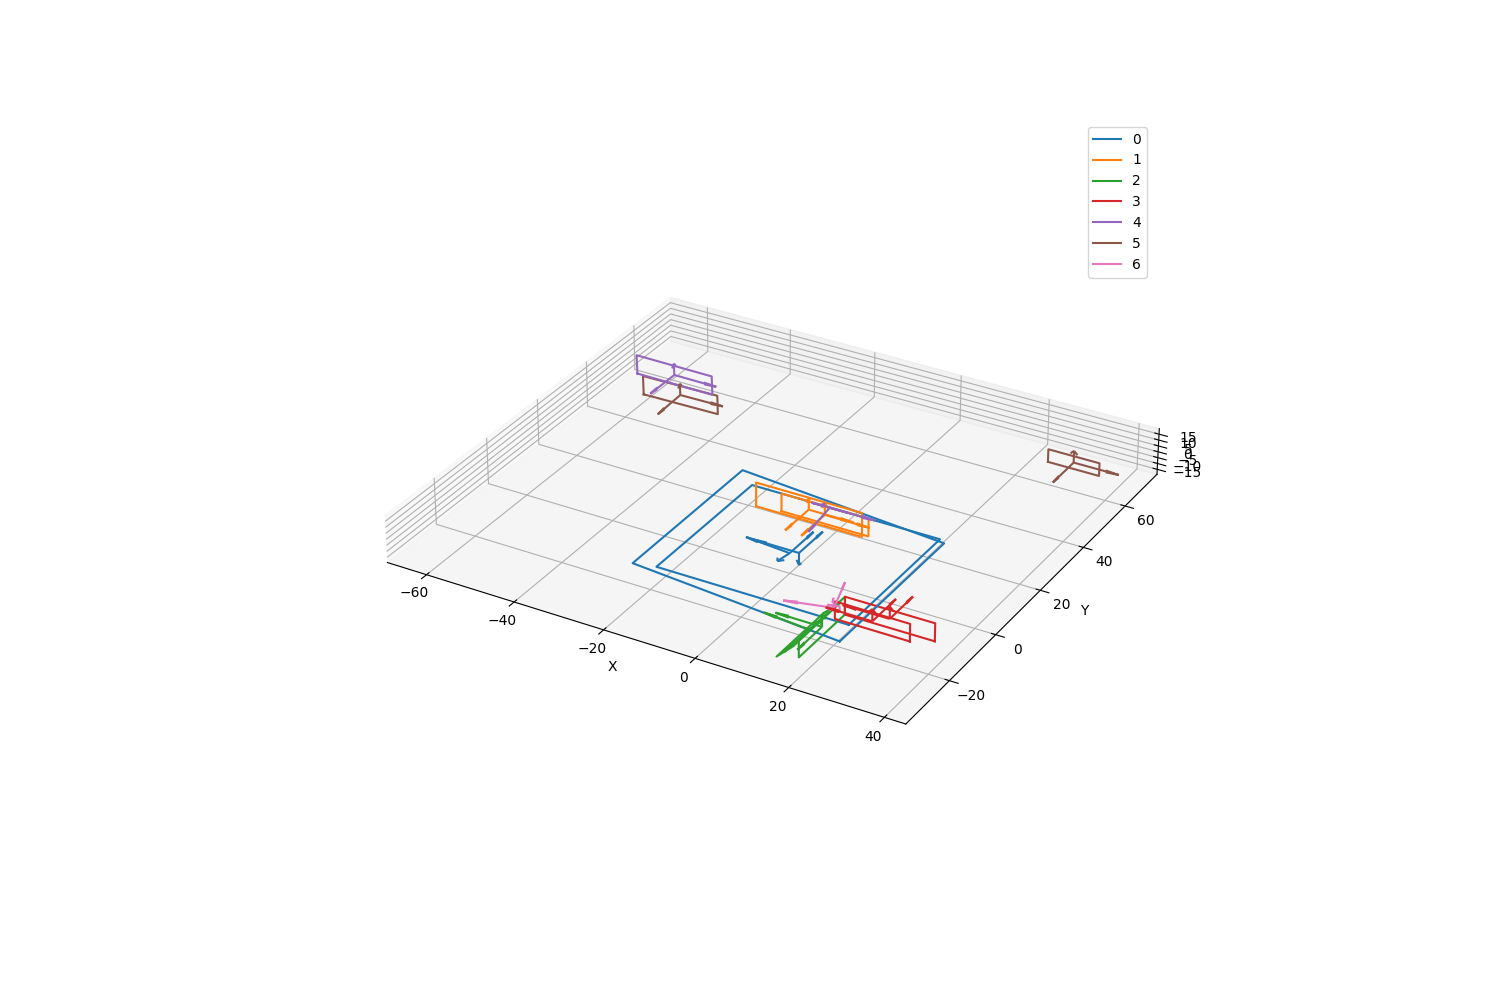

In [6]:
# Plot first 2 scans
ax = plot_3D_setup(PC_data[0])
for i, scan in enumerate(scans[0:2]):
    scan.plot(ax, show_normals=True)

# Color legend
num_colors = max([len(s.planes) for s in scans[0:2]])
color_legend(ax, num_colors)

In [21]:
# Extract normals and distances
# Use scans[0] as source and scans[1] as target
n_s, d_s, n_t, d_t = extract_corresponding_features(scans[0], scans[1])

Test Gauss-Newton registration

In [23]:
# Initial transformation
t = np.array([0, 1, 0])[:,None]
u = np.array([1, 0, 0])[:,None]
theta = 0.1
q = np.vstack((t, theta*u))

# Gauss-Newton
n_iters = 5
lmbda = 1e-3

for i in range(n_iters):
    r, n_q = residual(n_s, d_s, n_t, d_t, q)
    print("residual: ", r)
    J = jacobian(n_s, n_q)
    q = q + np.linalg.inv(J.T @ J + lmbda * np.eye(6)) @ J.T @ r

residual:  [[ 6.10046520e-05]
 [ 5.01826642e-03]
 [-1.01079777e-01]
 [-6.59782071e-03]
 [-5.01760492e-03]
 [ 9.98323707e-02]
 [ 3.16831749e-02]
 [ 6.23716891e-03]
 [-9.63075271e-02]
 [-9.85350026e-01]
 [ 6.50611304e-01]
 [-2.50729183e+00]]
residual:  [[ 0.07925224]
 [ 0.00711323]
 [-0.09004896]
 [-0.08224658]
 [-0.00791736]
 [ 0.094908  ]
 [ 0.08883007]
 [ 0.00957045]
 [-0.09972633]
 [ 1.32317139]
 [-1.81455495]
 [ 0.15466348]]
residual:  [[ 0.14215438]
 [ 0.01017864]
 [-0.01110014]
 [-0.14437192]
 [-0.01061167]
 [ 0.01635482]
 [ 0.14862741]
 [ 0.0102565 ]
 [-0.02080097]
 [ 1.95997102]
 [-2.42259937]
 [ 0.65475198]]
residual:  [[ 0.0766773 ]
 [ 0.00724458]
 [ 0.09165301]
 [-0.08178482]
 [-0.00728866]
 [-0.08851806]
 [ 0.09625957]
 [ 0.00612903]
 [ 0.08423918]
 [-0.06475632]
 [-0.41506805]
 [-1.25720055]]
residual:  [[ 0.02427773]
 [ 0.01960649]
 [-0.19659268]
 [-0.02751926]
 [-0.01857752]
 [ 0.18987521]
 [ 0.05427679]
 [ 0.01763813]
 [-0.1680369 ]
 [ 3.06664442]
 [-3.41638233]
 [ 1.965

In [24]:
q

array([[ 10.41610164],
       [  2.59577481],
       [-25.23057313],
       [ -2.38808994],
       [-23.94930954],
       [ -5.92398566]])

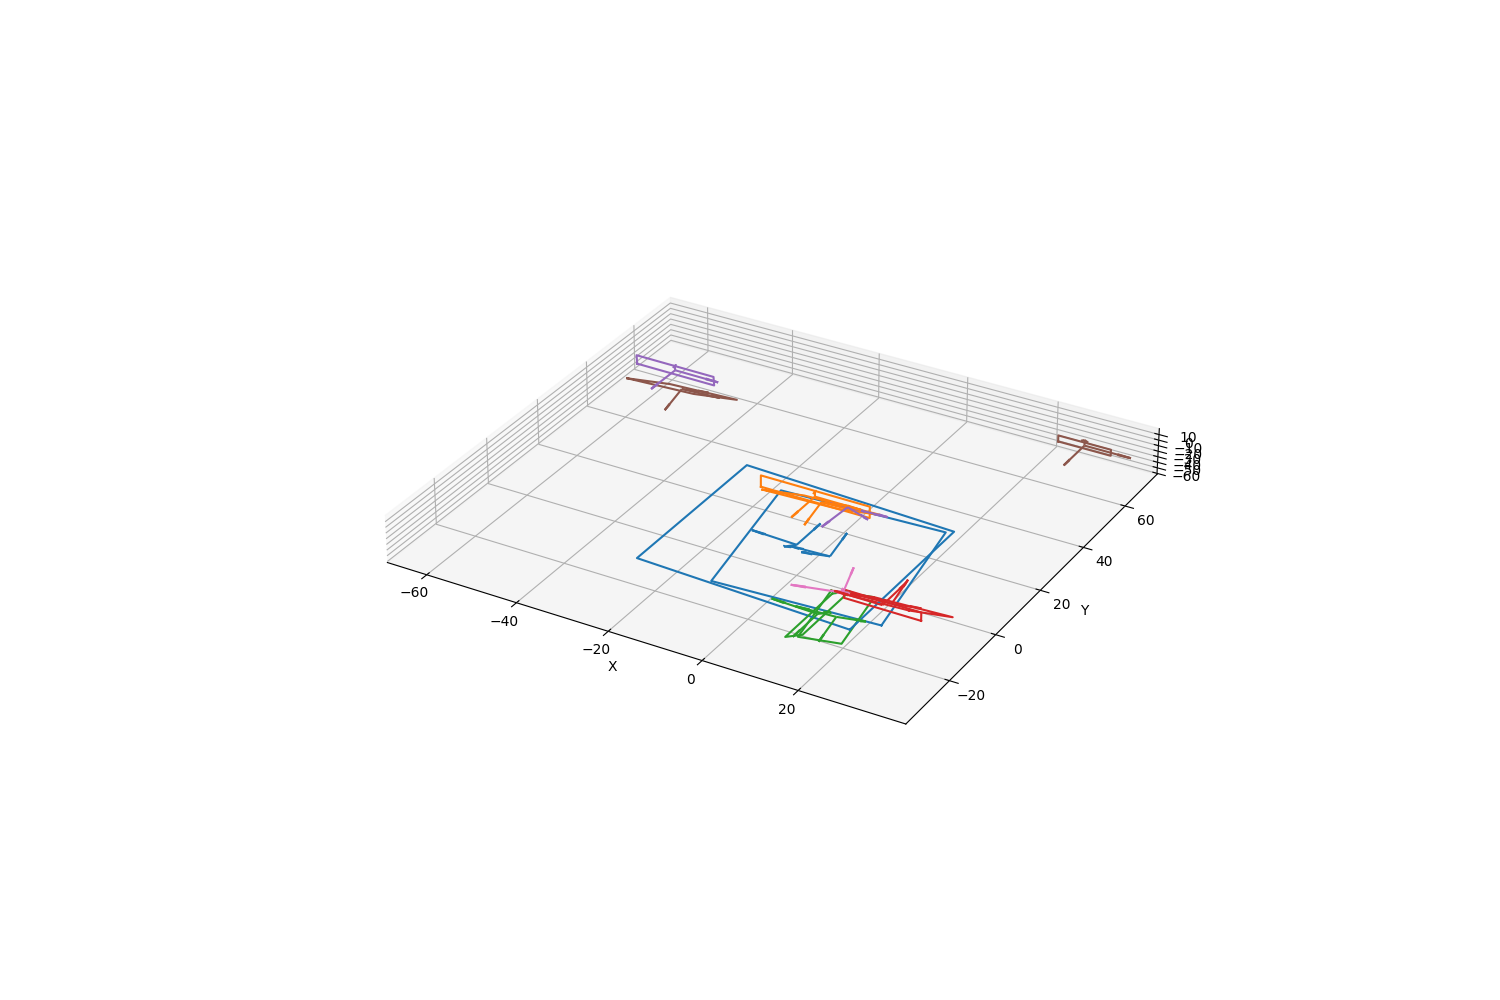

In [26]:
# Extract R and t from q
#t_est = q[:3]
t_est = np.zeros((3,1))
R_est = expmap(q[3:].flatten())

source_transformed = scans[0]
source_transformed.transform(R_est, t_est.flatten())
target = scans[1]

ax = plot_3D_setup(PC_data[0])

source_transformed.plot(ax, show_normals=True)
target.plot(ax, show_normals=True)


Test with two planes

In [12]:
from planeslam.geometry.plane import BoundedPlane
from planeslam.registration import expmap
from planeslam.scan import Scan
import copy

V1 = np.array([[-1, 1, -1],
              [1, 1, -1],
              [1, 1, 1],
              [-1, 1, 1]])
V2 = np.array([[-1, -1, -1],
              [-1, 1, -1],
              [-1, 1, 1],
              [-1, -1, 1]])
P = Scan([BoundedPlane(V1), BoundedPlane(V2)])

# Ground-truth transformation
t = np.array([0, -0.5, 0])[:,None]
u = np.array([0, 1, 0])[:,None]
theta = np.pi/12
q = np.vstack((t, theta*u))

R = expmap(q[3:].flatten())

print("t: ", t)
print("R: ", R)

vertex and face generation not yet implemented
t:  [[ 0. ]
 [-0.5]
 [ 0. ]]
R:  [[ 0.96592583  0.          0.25881905]
 [ 0.          1.          0.        ]
 [-0.25881905  0.          0.96592583]]


In [13]:
# P is source, Q is target
Q = copy.deepcopy(P)
Q.transform(R, t.flatten())

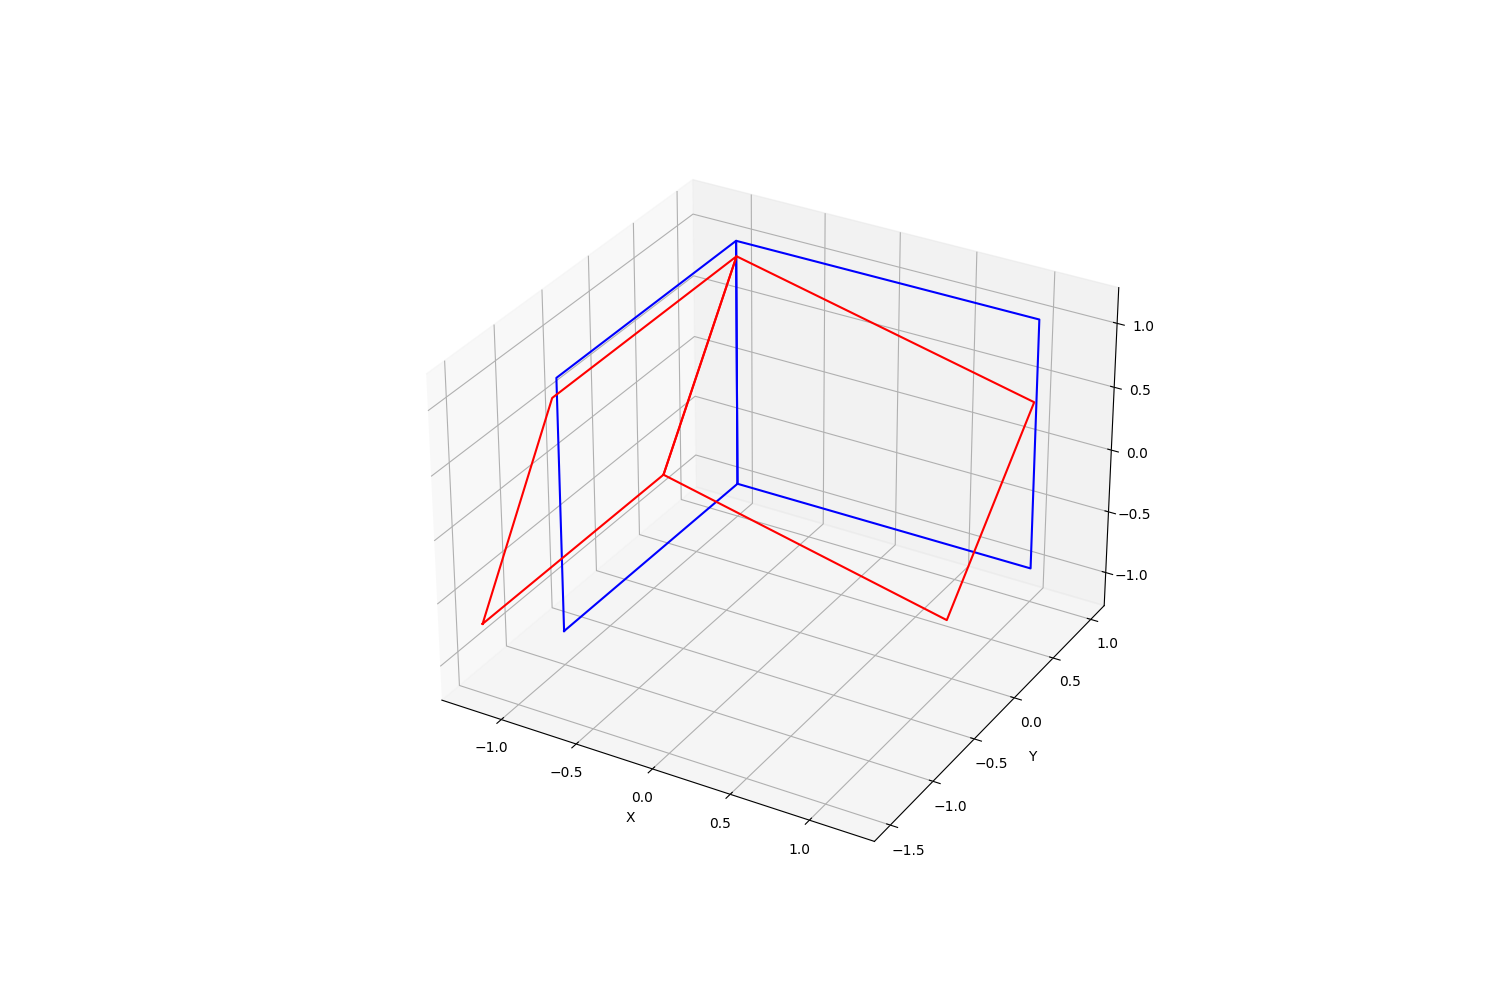

In [14]:
ax = plot_3D_setup()
P.plot(ax, color='b')
Q.plot(ax, color='r')

In [15]:
# n_s = P.normal 
# d_s = np.dot(P.normal.flatten(), P.center)
# n_t = Q.normal 
# d_t = np.dot(Q.normal.flatten(), Q.center)
correspondences = [(0,0), (1,1)]
n_s, d_s, n_t, d_t = extract_corresponding_features(P, Q, correspondences)

In [19]:
# Initial transformation
t = np.array([0, 1, 0])[:,None]
u = np.array([1, 0, 0])[:,None]
theta = 0.1
q = np.vstack((t, theta*u))

# Gauss-Newton
n_iters = 5
lmbda = 1e-8

for i in range(n_iters):
    r, n_q = residual(n_s, d_s, n_t, d_t, q)
    J = jacobian(n_s, n_q)
    dq = -np.linalg.inv(J.T @ J + lmbda * np.eye(6)) @ J.T @ r
    q[:3] = q[:3] + dq[:3]
    q[3:] = expmap(dq[3:].flatten()) @ q[3:]

In [20]:
# Extract R and t from q
t_est = q[:3]
R_est = expmap(q[3:].flatten())
print("t_est: ", t_est)
print("R_est: ", R_est)

# Apply transformation to source
P_T = copy.copy(P)
P_T.transform(R_est, t_est.flatten())

t_est:  [[-0.61376918]
 [ 0.82922632]
 [ 0.01796935]]
R_est:  [[ 0.99623492  0.06605836  0.05614516]
 [-0.06318958  0.99667589 -0.05142227]
 [-0.0593554   0.04768088  0.99709752]]


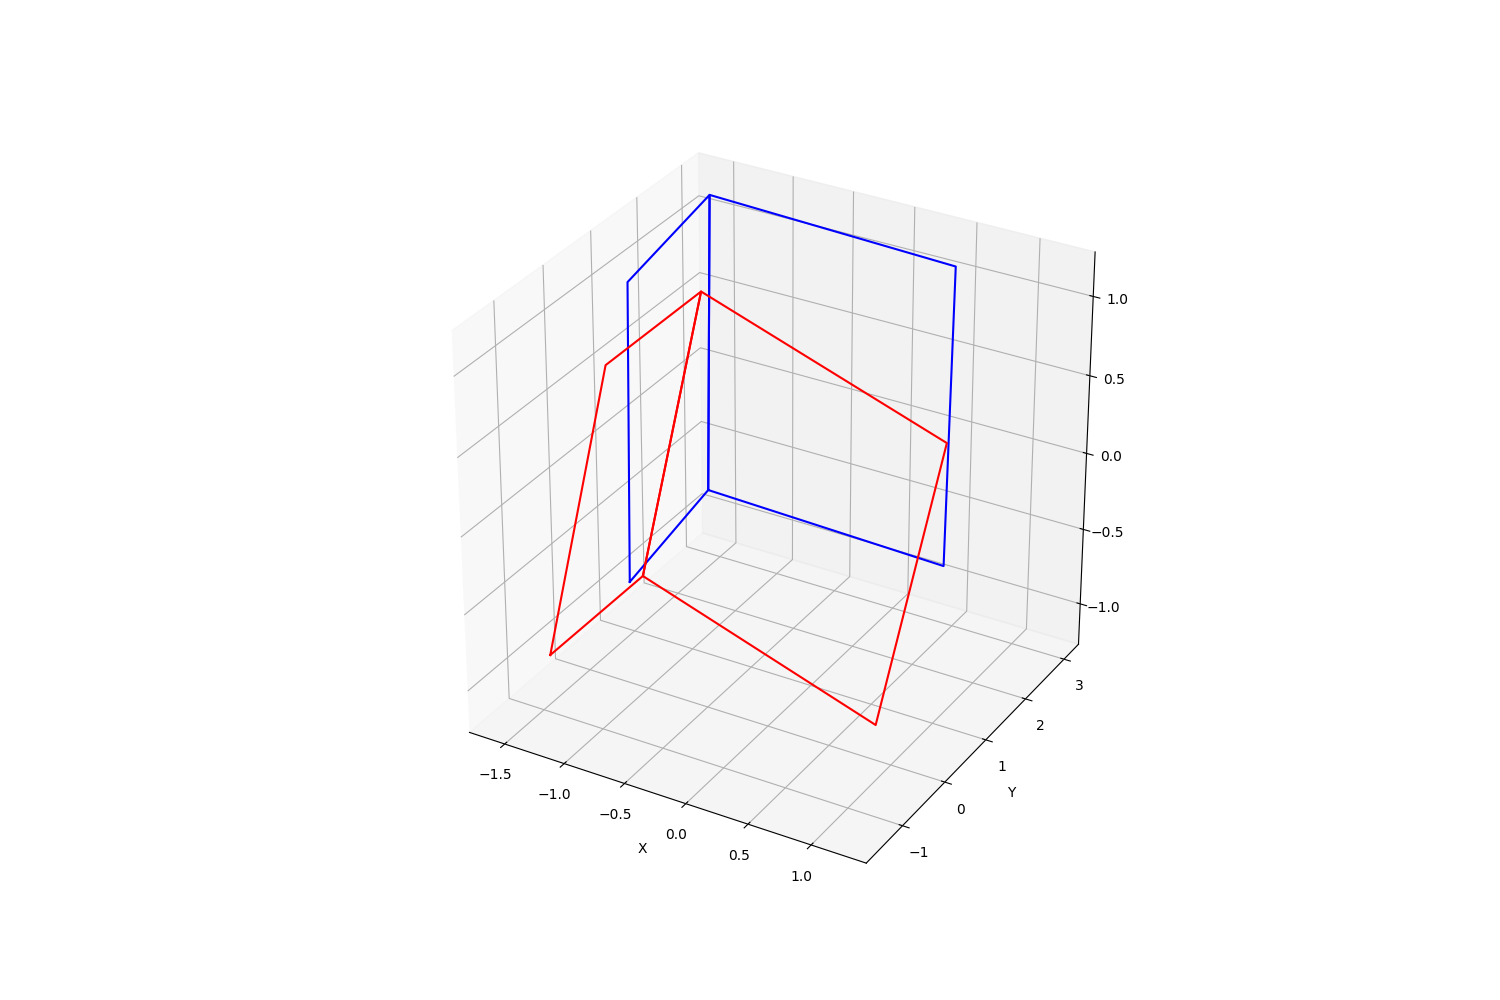

In [21]:
plot_P = np.vstack((np.eye(3), -np.eye(3)))
ax = plot_3D_setup(P=plot_P)
P_T.plot(ax, color='b')
Q.plot(ax, color='r')

Test with R as state and updating R thru exponential map

In [ ]:
from planeslam.geometry.plane import BoundedPlane
from planeslam.registration import expmap
from planeslam.scan import Scan
import copy

V1 = np.array([[-1, 1, -1],
              [1, 1, -1],
              [1, 1, 1],
              [-1, 1, 1]])
V2 = np.array([[-1, -1, -1],
              [-1, 1, -1],
              [-1, 1, 1],
              [-1, -1, 1]])
P = Scan([BoundedPlane(V1), BoundedPlane(V2)])

# Ground-truth transformation
t = np.array([0, -0.5, 0])[:,None]
u = np.array([0, 1, 0])[:,None]
theta = np.pi/12
q = np.vstack((t, theta*u))

R = expmap(q[3:].flatten())

print("t: ", t)
print("R: ", R)

# P is source, Q is target
Q = copy.deepcopy(P)
Q.transform(R, t.flatten())

correspondences = [(0,0), (1,1)]
n_s, d_s, n_t, d_t = extract_corresponding_features(P, Q, correspondences)

In [ ]:
# Initial transformation
t = np.array([0, 1, 0])[:,None]
u = np.array([1, 0, 0])[:,None]
theta = 0.1
q = np.vstack((t, theta*u))

# Gauss-Newton
n_iters = 5
lmbda = 1e-8

for i in range(n_iters):
    r, n_q = residual(n_s, d_s, n_t, d_t, q)
    J = jacobian(n_s, n_q)
    dq = -np.linalg.inv(J.T @ J + lmbda * np.eye(6)) @ J.T @ r
    q[:3] = q[:3] + dq[:3]
    q[3:] = expmap(dq[3:].flatten()) @ q[3:]